In [1]:
import PIL
import keras 
import numpy as np
from PIL import Image
import skimage
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Reading the dataset of images as an array of pixel values
from skimage.io import imread_collection
seq = imread_collection("img_align_celeba/*.jpg", conserve_memory=True)

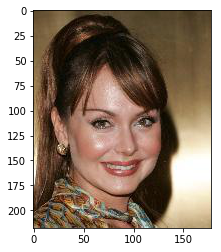

In [3]:
# Looking at one of the images
img = seq[8]
imgplot = plt.imshow(img)

In [3]:
# Shape of an image
print('Shape of an image in our dataset: {}'.format(img.shape))

NameError: name 'img' is not defined

In [18]:
N = 12800
images_i = np.zeros((N, seq[0].shape[0], seq[0].shape[1], 1))
images = np.zeros((N, 56,56,1))
for i in range(N):
    image = seq[i]
    images_i[i,:,:,0]= rgb2gray(image)
    images[i] = skimage.transform.resize(images_i[i], (56,56))

In [20]:
images.shape

(12800, 56, 56, 1)

In [19]:
num_images = N-1280
x_train = images[:num_images]
x_test = images[num_images: N]

In [21]:
x_train = np.reshape(x_train, (len(x_train), 56, 56, 1))
x_test = np.reshape(x_test, (len(x_test), 56, 56, 1))
image_size = x_train.shape[1]
dim_orig = image_size * image_size
x_train = np.reshape(x_train, [-1, dim_orig])
x_test = np.reshape(x_test, [-1, dim_orig])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (dim_orig, )
dim_interm = 512
batch_size = 128
latent_dim = 2
epochs = 50
x = Input(batch_shape=(batch_size, dim_orig))
h = Dense(dim_interm, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [22]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [23]:
decoder_h = Dense(dim_interm, activation='relu')
decoder_mean = Dense(dim_orig, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [24]:
vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean, name='vae_mlp')

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [25]:
def vae_loss(x, x_decoded_mean):
    xent_loss = binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [26]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [27]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test)
       )
vae.save_weights('vae1.h5')

Train on 11520 samples, validate on 1280 samples
Epoch 1/50
11520/11520 [==============================] - 17s 2ms/step - loss: 0.1842 - val_loss: 0.0118
Epoch 2/50
11520/11520 [==============================] - 19s 2ms/step - loss: 0.0030 - val_loss: 3.2402e-04
Epoch 3/50
11520/11520 [==============================] - 17s 2ms/step - loss: 1.6169e-04 - val_loss: 1.0014e-04
Epoch 4/50
11520/11520 [==============================] - 17s 1ms/step - loss: 9.4228e-05 - val_loss: 9.3449e-05
Epoch 5/50
11520/11520 [==============================] - 18s 2ms/step - loss: 9.1016e-05 - val_loss: 9.0056e-05
Epoch 6/50
11520/11520 [==============================] - 17s 1ms/step - loss: 8.9126e-05 - val_loss: 8.9316e-05
Epoch 7/50
11520/11520 [==============================] - 18s 2ms/step - loss: 8.8250e-05 - val_loss: 8.8577e-05
Epoch 8/50
11520/11520 [==============================] - 18s 2ms/step - loss: 8.7816e-05 - val_loss: 8.8575e-05
Epoch 9/50
11520/11520 [==============================] - 1

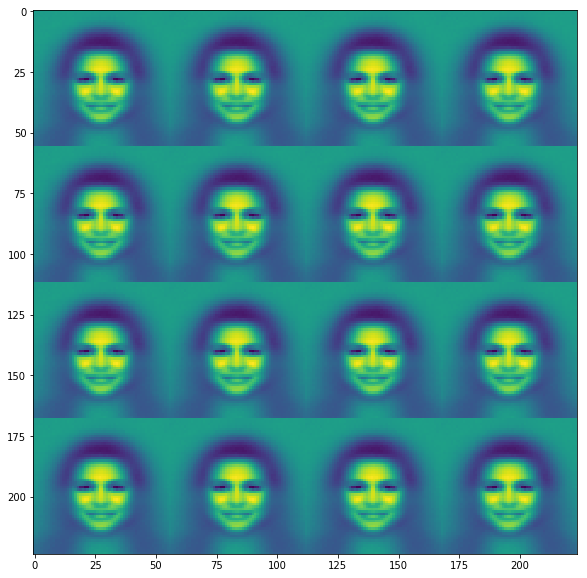

In [31]:
# display a 2D manifold of the digits
n = 4
# figure with 15x15 digits
digit_size = 56
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 0.001
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()